# Preparing NCAR Reanalysis Pressure for 2018-2019

This notebook was used to join NCAR reanalysis surface pressure files for use in barometric correction for the 2019 Tuolumne stream/hydroclimate data. 2018 and 2019 surface pressure data was retrieved from:

https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=195&tid=94905&vid=28

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join('..', '..', 'src')))

import config
import level_baro_utils

sys.path.remove(os.path.abspath(os.path.join('..', '..', 'src')))

In [19]:
# TODO: generalize
p1_path = '../data/ncar_reanalysis/pres.sfc.2018.nc'
p2_path = '../data/ncar_reanalysis/pres.sfc.2019.nc'

# sea level pressure (all lat/lon)
p1_sl_path = '../data/ncar_reanalysis/slp.2018.nc'
p2_sl_path = '../data/ncar_reanalysis/slp.2019.nc'

# surface temperature (all lat/lon)
st1_path = '../data/ncar_reanalysis/air.sig995.2018.nc'
st2_path = '../data/ncar_reanalysis/air.sig995.2019.nc'

# height
hgt_path = '../data/ncar_reanalysis/hgt.sfc.nc'

### Load Data

In [20]:
p1_global_ds = xr.open_dataset(p1_path)
p2_global_ds = xr.open_dataset(p2_path)

In [21]:
p1_global_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1460)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          4x daily NMC reanalysis (2014)
    history:        created 2017/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

### Isolate Data for Desired Lat/Long

Can view the range of lat/long by examining xarray.

In [22]:
p1 = p1_global_ds.pres.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)
p2 = p2_global_ds.pres.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)

### Plot Data Side By Side

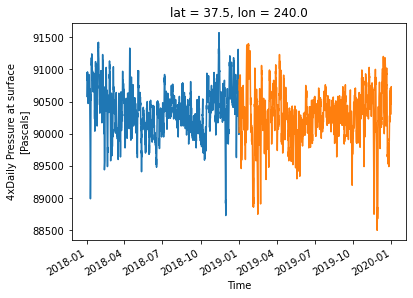

In [23]:
p1.plot()
p2.plot()

### Combine the Data

In [24]:
p1p2 = xr.merge([p1, p2])
p1p2.pres

<xarray.DataArray 'pres' (time: 2920)>
array([90580., 90830., 90910., ..., 90610., 90640., 90730.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Pressure at surface
    units:         Pascals
    precision:     -1
    GRIB_id:       1
    GRIB_name:     PRES
    var_desc:      Pressure
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [ 40000. 115000.]
    dataset:       NCEP Reanalysis
    actual_range:  [ 49360. 109540.]

### Inspect Result

Text(0, 0.5, 'Pa')

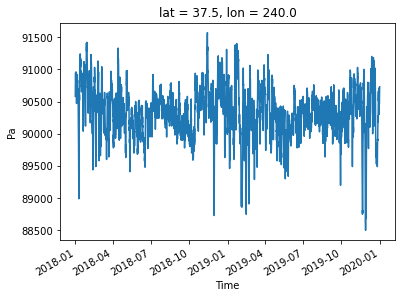

In [25]:
p1p2.pres.plot()
plt.ylabel('Pa')

### Apply Hypsometric Equation

#### 1. Use Sea Level Data and Hypsometric to Solve for Pixel Elevation

1.1 Load supplementary Data

In [26]:
# load sea level data
p1_sl_global_ds = xr.open_dataset(p1_sl_path)
p2_sl_global_ds = xr.open_dataset(p2_sl_path)

st1_global_ds = xr.open_dataset(st1_path)
st2_global_ds = xr.open_dataset(st2_path)

hgt_ds = xr.open_dataset(hgt_path)

1.2 Isolate Pixel Data

In [27]:
p1_sl = p1_sl_global_ds.slp.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)
p2_sl = p2_sl_global_ds.slp.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)

st1 = st1_global_ds.air.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)
st2 = st2_global_ds.air.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)

hgt = hgt_ds.hgt.sel(lat=config.NCAR_TUM_LAT, lon=config.NCAR_TUM_LON)

1.3 Join Series Into Large Series

In [28]:
p1p2_sl = xr.merge([p1_sl , p2_sl])
st1st2 = xr.merge([st1, st2])

1.4 Inspect series, pay special attention to units

<xarray.DataArray 'slp' (time: 2920)>
array([101830., 102130., 102360., ..., 102310., 102370., 102440.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Sea Level Pressure
    units:         Pascals
    precision:     0
    GRIB_id:       2
    GRIB_name:     PRMSL
    var_desc:      Sea Level Pressure
    level_desc:    Sea Level
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [ 87000. 115000.]
    dataset:       NCEP Reanalysis
    actual_range:  [ 93050. 111640.]

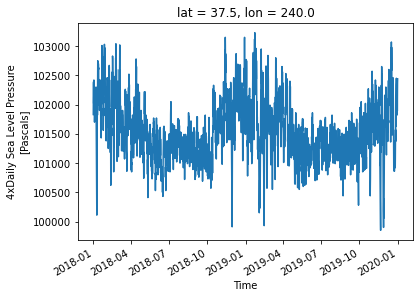

In [29]:
p1p2_sl.slp.plot()
p1p2_sl.slp

<xarray.DataArray 'air' (time: 2920)>
array([286.39996, 285.39996, 280.39996, ..., 273.69998, 272.6    ,
       272.89996], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [189.  323.3]

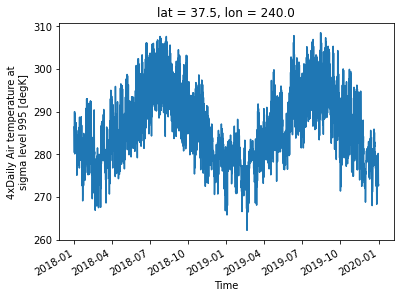

In [30]:
st1st2.air.plot()
st1st2.air

1.5 Use Hypsometric to Solve for Height of Pixel Surface

In [31]:
R = 8.31446261815324
g = 9.80665
lr = 6.5

#z = (R * tum_st_18_19.air * np.log(tum_pres_sl_18_19.slp / tum_pres_18_19.pres)) / (g) / (1 - (R * lr * np.log(tum_pres_sl_18_19.slp / tum_pres_18_19.pres) / (2*g)))
z = (29.3255131965 * st1st2.air * np.log(p1p2_sl.slp / p1p2.pres)) / (1 - (29.3255131965 * lr * (10**-3) * np.log(p1p2_sl.slp / p1p2.pres) / (2)))
print(np.mean(z))

<xarray.DataArray ()>
array(995.7385, dtype=float32)
Coordinates:
    lat      float32 37.5
    lon      float32 240.0


1.6 Compare Geopotential Height with Elevation found using Hypsometric Height

In [32]:
hgt

<xarray.DataArray 'hgt' (time: 1)>
array([993.], dtype=float32)
Coordinates:
    lat      float32 37.5
    lon      float32 240.0
  * time     (time) datetime64[ns] 1985-01-01
Attributes:
    long_name:     4xDaily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [-583. 5659.]
    valid_range:   [-1200.  6300.]
    dataset:       NCEP Reanalysis

1.7 Apply Hypsometric Equation Using Elevation Data of Tuolumne and Pixel

In [33]:
h_tum = 2627  # h2, m
h_pixel = 993  # h1, m
h = h_tum - h_pixel  # m
R = 8.31446261815324
g = 9.80665
P1 = p1p2
lapse_rate = -6.5 # C/km
T = st1st2.air + (lapse_rate * (h / 10**3) / 2)

#p2 = p1 * np.exp((-1 * h * g) / (R * T))
P2 = P1 * np.exp(0.0341 * (-1 * h) / (T))

P2

<xarray.Dataset>
Dimensions:  (time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Data variables:
    pres     (time) float32 7.429e+04 7.444e+04 ... 7.358e+04 7.367e+04

### Convert Pressure Data to cm H20

In [34]:
P2 *= level_baro_utils.PA_TO_CM
p1p2 *= level_baro_utils.PA_TO_CM

### Save Data

In [36]:
P2.to_netcdf('../data/ncar_reanalysis/hypso_pres.sfc.2018-2019.nc')
p1p2.to_netcdf('../data/ncar_reanalysis/pres.sfc.2018-2019.nc')